Reviewer 2 requested to explain why we fitted 10 models, which seems arbitrary. Here I try to justify that by analyzing the stability when more or less models are taken into account.

In [5]:
SAVE = True

In [1]:
import sys
sys.path.append('..')
import os
import pandas as pd
import eval_reallabor_utils
import data_utils

MRT = [2, 3]
combined_eval_file = []

for mrt in MRT:

    results_dirs = [
        f'v3_MRT{mrt}_batch02/00_summary_7stepsahead_individual_models',
        ]

    mrt_eval_file = pd.read_csv(data_utils.join_ordinal_bptt_path('results', results_dirs[0], 'evaluation.csv'), index_col=0)        
    mrt_eval_file['MRT'] = mrt

    use_days_from_file = data_utils.train_test_split_path(mrt, 'valid_first_alarms_no_con_smoothed.csv')
    valid_days = pd.read_csv(use_days_from_file, index_col=0)
    valid_days.columns = [int(c) for c in valid_days.columns]

    eval_reallabor_utils.clear_line_and_print(f'Filtering out invalid days')
    eval_only_valid_days = []
    for p, group in mrt_eval_file.groupby('participant'):
        if p in valid_days.columns:
            eval_only_valid_days.append(group.loc[group['test_day'].isin(valid_days[p])])
    mrt_eval_file = pd.concat(eval_only_valid_days, axis=0, ignore_index=True)

    mrt_eval_file['prediction'] = mrt_eval_file['prediction'].clip(0, 8)

    combined_eval_file.append(mrt_eval_file)

eval_reallabor_utils.clear_line_and_print(f'Creating grand combined evaluation file')
combined_eval_file = pd.concat(combined_eval_file, axis=0, ignore_index=False)

Creating grand combined evaluation file                                                                                                                                                                 

In [2]:
from eval_reallabor import reallabor_metrics
m_manager = reallabor_metrics.MetricsManager(combined_eval_file, ['participant', 'train_on_data_until_timestep', 'run'], use_gt_for_predicted_difference=False, only_nonzero_differences=True)

In [3]:
metrics, errorbars = {}, {}
# m_manager.raw_metrics.loc[(12, 2, 'KalmanFilter'), 'delta_interv_change_abs_residuals'] = np.nan
metrics['mae'] = m_manager.mae(func='mean')
errorbars['mae'] = m_manager.mae(func='sem')

In [4]:
import itertools as it 
import numpy as np
from joblib import Parallel, delayed

n_samples = 1000
group_sizes = range(1, 21)
bootstrap_results = []

def compute_bootstrap_sample(group_size, comb):
    group_results = metrics['mae'].groupby(['participant', 'train_on_data_until_timestep']).sample(group_size).mean()
    return pd.Series({'group_size': group_size, 'sample': comb, 'mae': group_results})

bootstrap_results = Parallel(n_jobs=10)(
    delayed(compute_bootstrap_sample)(group_size, comb)
    for group_size in group_sizes
    for comb in range(n_samples)
)

bootstrap_results = pd.concat(bootstrap_results, axis=1).T           
            

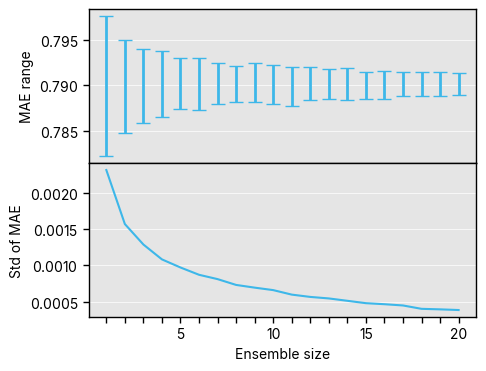

In [11]:
import matplotlib.pyplot as plt

import plotting_utils
from plotting_styles import PaperStyle

with PaperStyle():

    fig, axes = plt.subplots(2, 1, figsize=(5, 4), sharex=True)
    grouper = bootstrap_results.groupby('group_size')
    axes[0].errorbar(group_sizes, grouper['mae'].mean(), yerr=[grouper['mae'].mean() - grouper['mae'].min(), grouper['mae'].max() - grouper['mae'].mean()], 
                marker='', linestyle='', capsize=5, elinewidth=2)
    axes[0].set(ylabel='MAE range')
    plotting_utils.adjust_ylim(axes[0], 0.05, 0.05)
    axes[1].plot(group_sizes, grouper['mae'].std(), marker='', linestyle='-')
    labels = [''] * len(group_sizes)
    labels[4::5] = [str(gs) for gs in group_sizes[4::5]]
    axes[1].set(xlabel='Ensemble size', ylabel='Std of MAE', xticks=group_sizes, xticklabels=labels)
    plotting_utils.adjust_ylim(axes[1], 0.05, 0.05)
    plt.subplots_adjust(hspace=0.0)

    if SAVE:
        plt.savefig(data_utils.join_ordinal_bptt_path('results', '_paper', 'stability_of_ensemble_predictors.svg'))
    plt.show()